In [15]:
# -------------------------------------------------------------
# Step 1: Import necessary libraries
# -------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


sns.set_theme(context="notebook", style="whitegrid")
print("✅ Libraries imported.")


✅ Libraries imported.


In [2]:
from google.colab import drive


drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# -------------------------------------------------------------
# Step 2: Load the raw dataset
# -------------------------------------------------------------
print("📥 Loading dataset...")

df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/House Pricing/house_data.csv")

print("✅ Dataset loaded successfully!")
print("Initial data shape:", df.shape)
print("\n🔍 Preview of data:")
print(df.head())


📥 Loading dataset...
✅ Dataset loaded successfully!
Initial data shape: (84, 7)

🔍 Preview of data:
     price  sqft  bedrooms  bathrooms    location  year_built  condition
0   495000  1527         2        1.5      Suburb        1956       Good
1   752000  2526         3        2.5    Downtown        1998  Excellent
2   319000  1622         2        1.5       Rural        1975       Fair
3  1210000  3102         4        3.0  Waterfront        2005  Excellent
4   462000  1835         2        2.0       Urban        1982       Good


In [ ]:
# Make a copy to avoid modifying the original dataframe
df_cleaned = df.copy()

# Handle missing values
for column in df_cleaned.columns:
    missing_count = df_cleaned[column].isnull().sum()
    if missing_count > 0:
        # For numeric columns, fill with median
        if pd.api.types.is_numeric_dtype(df_cleaned[column]):
            median_value = df_cleaned[column].median()
            df_cleaned[column] = df_cleaned[column].fillna(median_value)
        # For categorical columns, fill with mode
        else:
            mode_value = df_cleaned[column].mode()[0]
            df_cleaned[column] = df_cleaned[column].fillna(mode_value)

# Handle outliers in price (target variable)
# Using IQR method to identify outliers
Q1 = df_cleaned['price'].quantile(0.25)
Q3 = df_cleaned['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out extreme outliers
outliers = df_cleaned[(df_cleaned['price'] < lower_bound) |
                      (df_cleaned['price'] > upper_bound)]

if not outliers.empty:
    df_cleaned = df_cleaned[(df_cleaned['price'] >= lower_bound) &
                            (df_cleaned['price'] <= upper_bound)]

In [ ]:
print(f"lower_bound: {lower_bound}")
print(f"upper_bound: {upper_bound}")
print("******" * 5)
print(outliers)
print("******" * 5)
print(df_cleaned.shape)


lower_bound:-158250.0
upper_bound:1261750.0
******************************
      price  sqft  bedrooms  bathrooms    location  year_built  condition
8   1680000  3850         5        4.5  Waterfront        2012  Excellent
23  1380000  3480         4        4.0  Waterfront        2015  Excellent
38  1580000  3680         5        4.0  Waterfront        2018  Excellent
48  1280000  3280         4        3.5  Waterfront        2012  Excellent
53  1420000  3520         5        4.0  Waterfront        2017  Excellent
63  1340000  3420         4        4.0  Waterfront        2014  Excellent
78  1520000  3620         5        4.0  Waterfront        2019  Excellent
******************************
(77, 7)


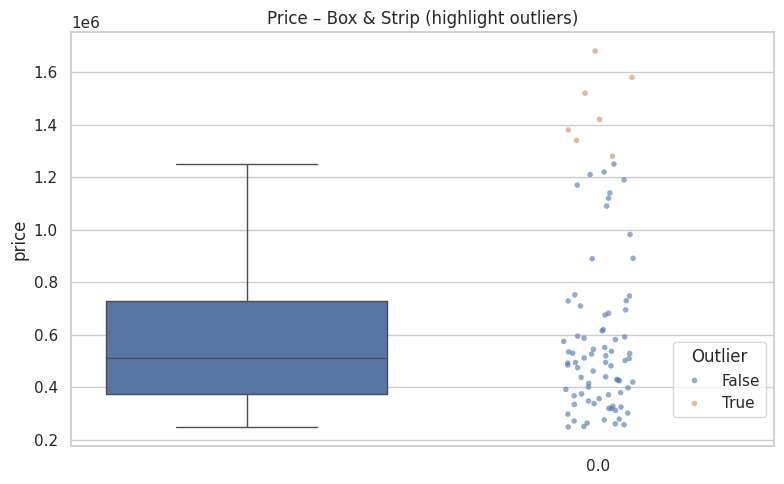

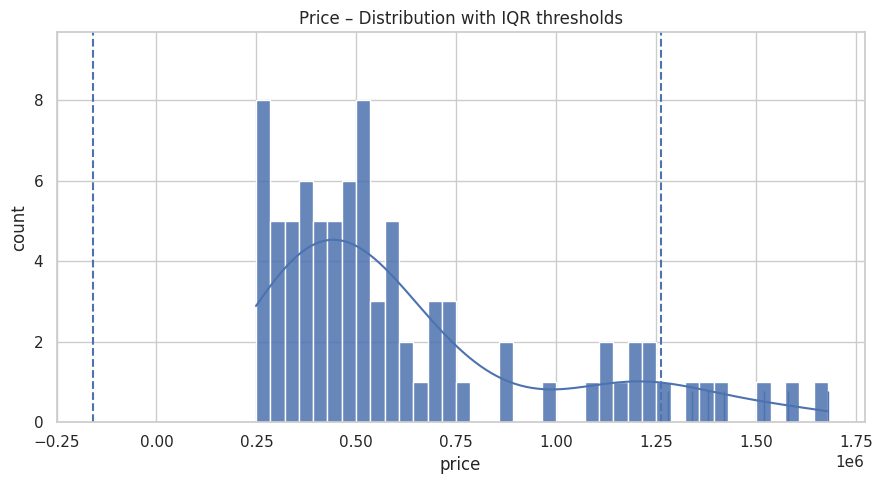

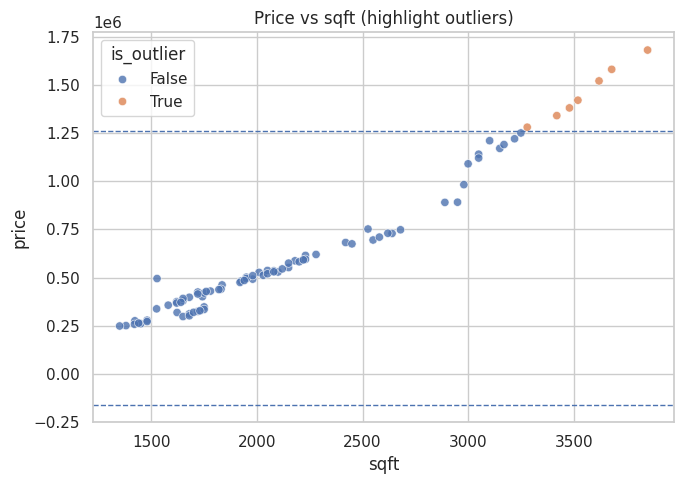

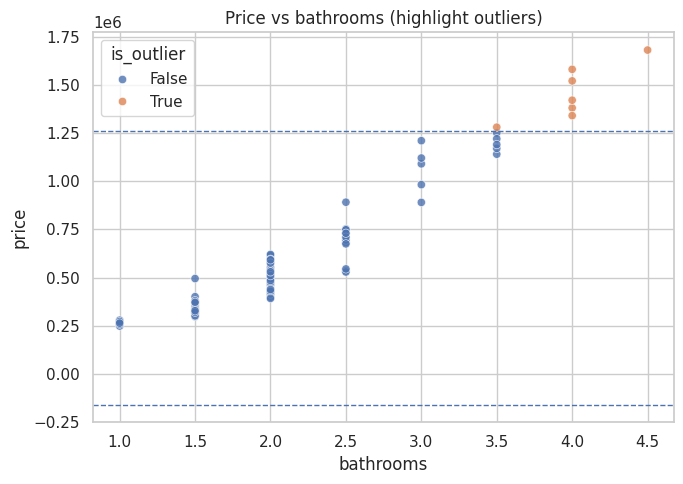

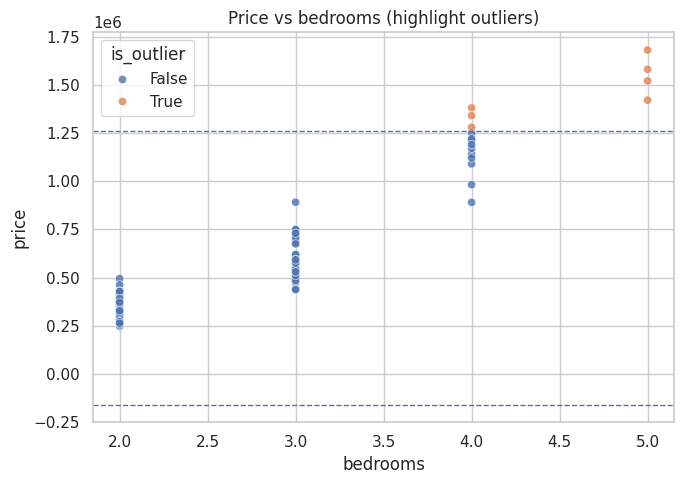

Outliers: 7/84 (8.33%)
IQR thresholds: lower=-158250.000, upper=1261750.000


In [16]:
# 1) Gắn cờ outlier trên bản sao để vẽ
df_viz = df.copy()
df_viz["is_outlier"] = df_viz.index.isin(outliers.index)

# 2) BOX + STRIP: Nhìn nhanh phân bố và các điểm outlier
plt.figure(figsize=(8, 5))
ax = sns.boxplot(data=df_viz, y="price", showfliers=False)
sns.stripplot(data=df_viz, y="price", x=np.zeros(len(df_viz)),  # gom thành 1 cột
              hue="is_outlier", dodge=False, alpha=0.6, size=4)
ax.set_title("Price – Box & Strip (highlight outliers)")
ax.set_xlabel("")
ax.legend(title="Outlier", loc="lower right", bbox_to_anchor=(1, 0.05))
plt.tight_layout()
plt.show()

# 3) HIST/KDE + NGƯỠNG IQR: Hiển thị ranh giới outlier
plt.figure(figsize=(9, 5))
sns.histplot(df_viz["price"], kde=True, bins=40, alpha=0.85)
# Vẽ ngưỡng IQR
plt.axvline(lower_bound, linestyle="--", linewidth=1.5)
plt.axvline(upper_bound, linestyle="--", linewidth=1.5)
# Rug cho các outlier (nằm dọc trục x)
if not outliers.empty:
    sns.rugplot(outliers["price"], height=0.08)
plt.title("Price – Distribution with IQR thresholds")
plt.xlabel("price")
plt.ylabel("count")
plt.tight_layout()
plt.show()

# 4) SCATTER so với các biến số liên quan nhất
#    Chọn tối đa 3 biến số (numeric) tương quan mạnh nhất với price (khác price)
num_cols = df_viz.select_dtypes(include=[np.number]).columns.tolist()
feat_candidates = [c for c in num_cols if c != "price"]
if feat_candidates:
    # Tính tương quan |corr| với price (bỏ NaN)
    corrs = (
        df_viz[feat_candidates + ["price"]]
        .corr(numeric_only=True)["price"]
        .drop(labels=["price"])
        .abs()
        .sort_values(ascending=False)
    )
    top_feats = corrs.head(3).index.tolist()

    for feat in top_feats:
        plt.figure(figsize=(7, 5))
        sns.scatterplot(
            data=df_viz,
            x=feat, y="price",
            hue="is_outlier", alpha=0.8
        )
        # Vẽ ngưỡng IQR theo trục y (price)
        plt.axhline(lower_bound, linestyle="--", linewidth=1)
        plt.axhline(upper_bound, linestyle="--", linewidth=1)
        plt.title(f"Price vs {feat} (highlight outliers)")
        plt.tight_layout()
        plt.show()

# 5) Tóm tắt nhanh số lượng outlier
n_out = int(df_viz["is_outlier"].sum())
n_all = len(df_viz)
pct_out = (n_out / n_all * 100) if n_all else 0
print(f"Outliers: {n_out}/{n_all} ({pct_out:.2f}%)")
print(f"IQR thresholds: lower={lower_bound:.3f}, upper={upper_bound:.3f}")

In [21]:
# -------------------------------------------------------------
# Step 3: Understand structure — schema, datatypes, nulls
# -------------------------------------------------------------
print("\n📊 Data types and null value check:")
print(df_cleaned.info())

print("\n❓ Any missing values?")
print(df_cleaned.isnull().sum())

print("\n🗡 Drop malformed rows")
df_cleaned = df_cleaned.dropna()
df_cleaned



📊 Data types and null value check:
<class 'pandas.core.frame.DataFrame'>
Index: 77 entries, 0 to 83
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   price       77 non-null     int64  
 1   sqft        77 non-null     int64  
 2   bedrooms    77 non-null     int64  
 3   bathrooms   77 non-null     float64
 4   location    77 non-null     object 
 5   year_built  77 non-null     int64  
 6   condition   77 non-null     object 
dtypes: float64(1), int64(4), object(2)
memory usage: 4.8+ KB
None

❓ Any missing values?
price         0
sqft          0
bedrooms      0
bathrooms     0
location      0
year_built    0
condition     0
dtype: int64

🗡 Drop malformed rows


,price,sqft,bedrooms,bathrooms,location,year_built,condition
0,495000,1527,2,1.5,Suburb,1956,Good
1,752000,2526,3,2.5,Downtown,1998,Excellent
2,319000,1622,2,1.5,Rural,1975,Fair
3,1210000,3102,4,3.0,Waterfront,2005,Excellent
4,462000,1835,2,2.0,Urban,1982,Good
...,...,...,...,...,...,...,...
79,530000,2080,3,2.0,Urban,1991,Good
80,372000,1640,2,1.5,Suburb,1963,Fair
81,592000,2220,3,2.0,Downtown,1985,Good
82,328000,1730,2,1.5,Rural,1965,Fair


In [22]:
# -------------------------------------------------------------
# Step 4: Standardize column names (basic cleanup)
# -------------------------------------------------------------
print("\n🧹 Cleaning column names (lowercase, underscores)...")

df_cleaned.columns = df_cleaned.columns.str.strip().str.lower().str.replace(" ", "_")
print("✅ Column names standardized:")
print(df_cleaned.columns.tolist())



🧹 Cleaning column names (lowercase, underscores)...
✅ Column names standardized:
['price', 'sqft', 'bedrooms', 'bathrooms', 'location', 'year_built', 'condition']


In [23]:
# -------------------------------------------------------------
# Step 5: Basic stats check (spot outliers or issues)
# -------------------------------------------------------------
print("\n📈 Basic summary stats for numeric columns:")
print(df_cleaned.describe())



📈 Basic summary stats for numeric columns:
              price         sqft   bedrooms  bathrooms   year_built
count  7.700000e+01    77.000000  77.000000  77.000000    77.000000
mean   5.532338e+05  2068.000000   2.701299   2.025974  1979.025974
std    2.651523e+05   522.756711   0.689488   0.643265    17.427273
min    2.490000e+05  1350.000000   2.000000   1.000000  1947.000000
25%    3.680000e+05  1680.000000   2.000000   1.500000  1965.000000
50%    4.950000e+05  1950.000000   3.000000   2.000000  1981.000000
75%    6.200000e+05  2280.000000   3.000000   2.500000  1992.000000
max    1.250000e+06  3250.000000   4.000000   3.500000  2010.000000



📊 Plotting distribution of house prices...


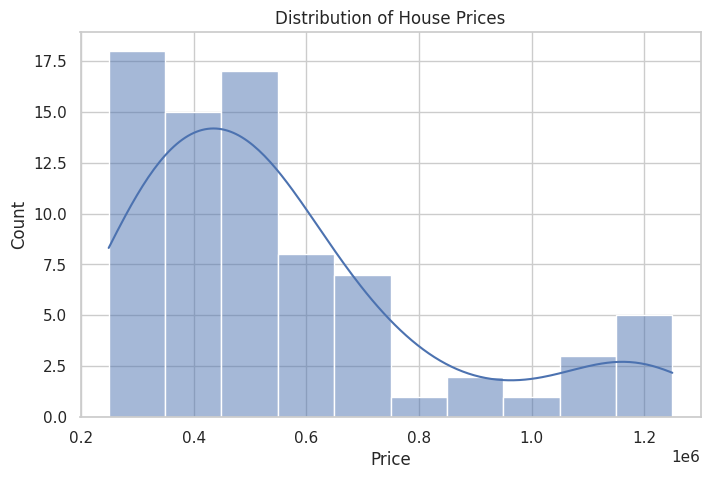

In [24]:
# -------------------------------------------------------------
# Step 6: Visual check for distributions (e.g. price, sqft)
# -------------------------------------------------------------
print("\n📊 Plotting distribution of house prices...")

plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned["price"], kde=True, bins=10)
plt.title("Distribution of House Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()


In [25]:
# -------------------------------------------------------------
# Step 7: Check for obvious data issues
# -------------------------------------------------------------
print("\n🔍 Looking for negative or unrealistic values...")

for col in ['price', 'sqft', 'bedrooms', 'bathrooms', 'year_built']:
    invalid = df_cleaned[df_cleaned[col] < 0]
    if not invalid.empty:
        print(f"⚠️ Found negative values in {col}:\n{invalid}")
    else:
        print(f"✅ No negative values found in {col}.")



🔍 Looking for negative or unrealistic values...
✅ No negative values found in price.
✅ No negative values found in sqft.
✅ No negative values found in bedrooms.
✅ No negative values found in bathrooms.
✅ No negative values found in year_built.


In [26]:
# -------------------------------------------------------------
# Step 8: Drop duplicates if any
# -------------------------------------------------------------
print("\n🧹 Checking for duplicate rows...")

duplicates = df_cleaned.duplicated().sum()
if duplicates > 0:
    print(f"⚠️ Found {duplicates} duplicate rows. Dropping them...")
    df = df_cleaned.drop_duplicates()
else:
    print("✅ No duplicate rows found.")



🧹 Checking for duplicate rows...
✅ No duplicate rows found.


In [27]:
# -------------------------------------------------------------
# Step 9: Save the cleaned version (optional here)
# -------------------------------------------------------------
print("\n💾 Saving cleaned version to interim file (optional step)...")

# Uncomment if you want to save at this point
df_cleaned.to_csv("/content/drive/MyDrive/Colab Notebooks/House Pricing/cleaned_house_data.csv", index=False)
print("✅ Data engineering preprocessing complete!")



💾 Saving cleaned version to interim file (optional step)...
✅ Data engineering preprocessing complete!
